(bread-prices)=
# Bread Prices
---

![udana.jpg](img/udana.jpg)

$^{1}$Image credit: https://www.zumarragakoazoka.eus/es/

## Background
As elsewhere, bread prices also increased in Spain during 2022. That made me wonder which bread types where cheaper among the ones I can buy around. That is, considering the price per weight unit.

Basically three different types of bread are sold in my town:

- In the twice-a-week street market, a bunch of local bakers sell home-made artisan-type loaves.
- In the bakery, breads baked every night in their local bakery are sold.
- In stores (supermarkets, convenience stores), you can find baguettes which are baked on site using pre-made dough that comes frozen from a factory.

I had the impression that `market` breads were more expensive and `store` breads were cheaper, with `bakery` breads in the middle. But I did not really know, it was just an idea probably coming from the different approaches: from more artisan to more industrial.

So I decided to conduct a little study.

## The data
During a few months I collected data from the bread units I bought —all of them white-wheat breads. Whenever I came back home with my loaf or baguette, I weighed it on my scale and wrote down the grams and the price in euros. I gave each a nickname after its name (if it had one) or the seller's, adding some other distintive information in the designation. In most cases I bought the same bread more than once to get mean values in this study, as breads never weigh exactly the same.

In [53]:
# Import basic packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Read the data
breads = pd.read_csv("data/breads.csv")
print(breads)

                  name  weight   eur    type
0          Ilargi_350b     340  1.50  bakery
1          Ilargi_250b     278  1.40  bakery
2   Ilargi_Bikoitz_300     260  1.40  bakery
3         Labekoa_350b     357  1.50  bakery
4       Ilargi_Baserri     600  2.55  bakery
..                 ...     ...   ...     ...
80      Eroski_Rustica     399  1.59   store
81          Udana_900l     855  2.50  market
82          Udana_700l     670  1.90  market
83      Ilargi_Baserri     593  2.30  bakery
84        Makatza_500l     504  1.50  market

[85 rows x 4 columns]


## Exploratory Data Analysis

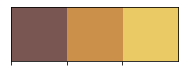

In [54]:
# Define color order and palette for the plots
hue_order = ["market", "bakery", "store"]
palette = ["#7A5652", "#CB9049", "#E9CA65"]

# Plot palette
sns.palplot(sns.color_palette(palette))

### Count breads by type

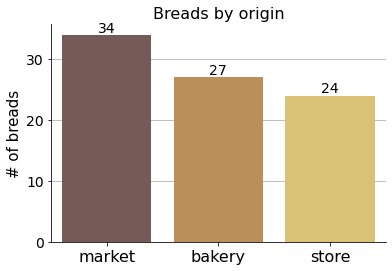

In [55]:
# Plot
fig, ax = plt.subplots(figsize=(6, 4))

sns.countplot(x="type", data=breads, ax=ax,
              order=hue_order, palette=palette)

ax.grid(axis="y")
ax.set_axisbelow(True)
ax.tick_params(axis='x', labelsize=16, rotation=0)
ax.tick_params(axis='y', labelsize=14)
ax.set_title("Breads by origin", size=16)
ax.set_xlabel("")
ax.set_ylabel("# of breads", size=15)
ax.bar_label(ax.containers[0], size=14)
sns.despine()

plt.show()

This is the distribution by type of the total number of breads considered in this study. The imbalance loosely reflects the difference in existing bread sizes for each type (store breads are normally small baguettes, while in the market breads span from large loaves to small buns).

### Best price chart
The first thing I wanted to know right away was the cheapest bread of all per weight unit (kilogram).

In [56]:
# Add column with bread price per kg
breads["eur/kg"] = 1000 * breads["eur"] / breads["weight"]

# Sort values by bread weight per euro column
breads = breads.sort_values("eur/kg")
print(breads.head(10))

                name  weight   eur    type    eur/kg
67    Eroski_Mediana     243  0.45   store  1.851852
60    Eroski_Mediana     224  0.45   store  2.008929
55        Dia_Molino     244  0.55   store  2.254098
61   Eroski_Baguette     218  0.50   store  2.293578
65        Dia_Molino     232  0.55   store  2.370690
52      Makatza_900l     915  2.25  market  2.459016
8       Makatza_900l     900  2.25  market  2.500000
59    Dia_Parisienne     298  0.75   store  2.516779
7         Udana_900l     908  2.50  market  2.753304
62  Eroski_Campesina     301  0.84   store  2.790698


As we can see, the top-10 list is populated with store breads mainly (lightweights), but there are also weighty market breads.

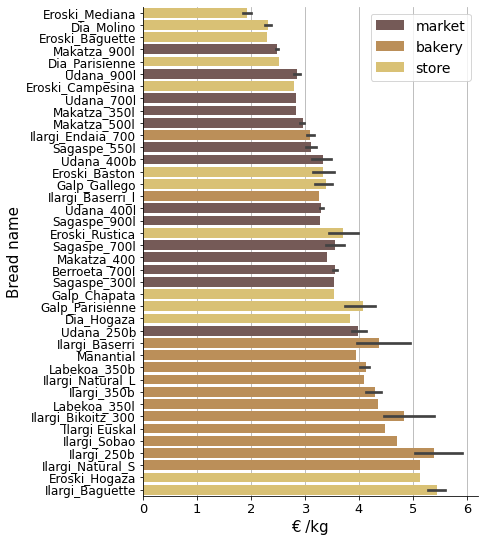

In [57]:
# Plot
fig, ax = plt.subplots(figsize=(6, 9))

sns.barplot(x="eur/kg", y="name", data=breads, ax=ax,
            hue="type", hue_order=hue_order, palette=palette,
            dodge=False)

ax.grid(axis="x")
ax.set_axisbelow(True)
ax.tick_params(axis='x', labelsize=13, rotation=0)
ax.tick_params(axis='y', labelsize=12)
ax.set_title("", size=16)
ax.set_xlabel("€ /kg", fontsize=15)
ax.set_ylabel("Bread name", fontsize=15)
ax.legend(fontsize=14)
sns.despine()

plt.show()

This bar plot shows all breads but without repeating them, i.e. calculating average values for same bread names. Different colours should be helpful to gain insight about the price distribution. However, we are mixing small bread units with large ones in this chart, surely not the best way to make a comparison.

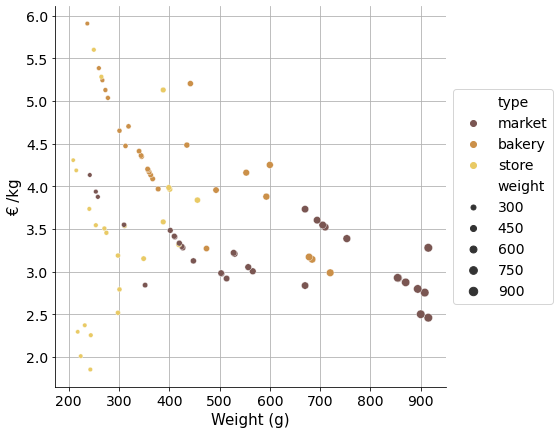

In [58]:
# Plot
fig, ax = plt.subplots(figsize=(7, 7))

sns.scatterplot(x="weight", y="eur/kg", data=breads, ax=ax,
                     hue="type", hue_order=hue_order, palette=palette,
                     size="weight")

ax.grid(axis="both")
ax.set_axisbelow(True)
ax.tick_params(axis='x', labelsize=14, rotation=0)
ax.tick_params(axis='y', labelsize=14)
ax.set_title("", size=16)
ax.set_xlabel("Weight (g)", fontsize=15)
ax.set_ylabel("€ /kg", fontsize=15)
ax.legend(bbox_to_anchor=(1.0, 0.5), loc='center left', fontsize=14)
sns.despine()

plt.show()

To compare prices properly and be able to conclude price differences between `market`, `bakery` and `store` breads, we need to cluster these observations in categorical size groups.

### Cluster sizes
As with clothing, I decided to establish 5 size groups:
- "XS" (eXtra Small)
- "S" (Small)
- "M" (Medium)
- "L" (Large)
- "XL" (eXtra Large)

And instead of defining the boundaries myself and placing each bread in its corresponding group,
I had a k-means clustering model work for me to find these clusters in the data.

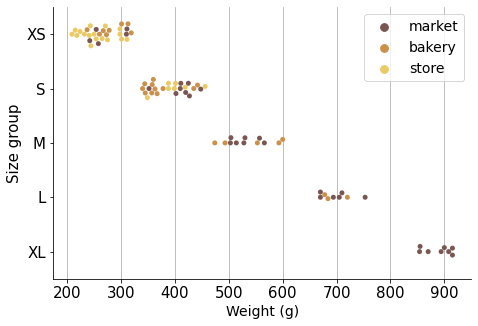

In [59]:
# Import Scikit-learn package
from sklearn.cluster import KMeans

# Define cluster names
sizes = ["XS", "S", "M", "L", "XL"]

# Create a KMeans model instance
kmeans = KMeans(n_clusters=len(sizes), random_state=0)

# Sort values by weight
breads = breads.sort_values("weight")

# Create a sorted 2D array of weights to feed the model
weights = np.array(breads["weight"]).reshape(-1, 1)

# Fit model
kmeans.fit(weights)

# Obtained cluster labels
labels = kmeans.labels_

# Center points consistent with labels
centers = kmeans.cluster_centers_

# Sort center points in ascending order
centers_df = pd.DataFrame(centers).sort_values(0)

# Reset index to column: corresponds exactly to the label!
centers_df = centers_df.reset_index()

# Name columns
centers_df.columns=["labels", "center"]

# Incorporate size tags related to labels
centers_df["sizes"] = sizes

# Create a dict to link label to size tag
key = {label: size for label, size in zip(centers_df["labels"], centers_df["sizes"])}

# Create new column with labels obtained from kmeans model
breads["label"] = labels

# Create new column with size tags linked to labels
breads["size"] = [key[i] for i in breads["label"]]

# Plot
fig, ax = plt.subplots(figsize=(7.5, 5))

sns.swarmplot(x="weight", y="size", data=breads, ax=ax,
              hue="type", hue_order=hue_order, palette=palette)

ax.grid(axis="x")
ax.set_axisbelow(True)
ax.tick_params(axis='x', labelsize=15, rotation=0)
ax.tick_params(axis='y', labelsize=15)
ax.set_title("", size=16)
ax.set_xlabel("Weight (g)", fontsize=14)
ax.set_ylabel("Size group", fontsize=15)
ax.legend(fontsize=14)
sns.despine()

plt.show()

Now that we have breads grouped in similar size groups, the observations are ready for comparison.

### Price comparison

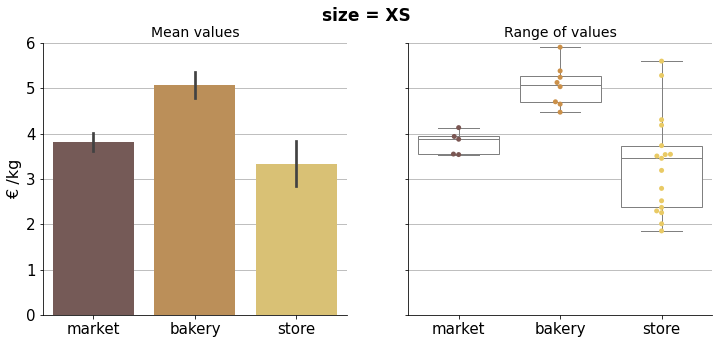

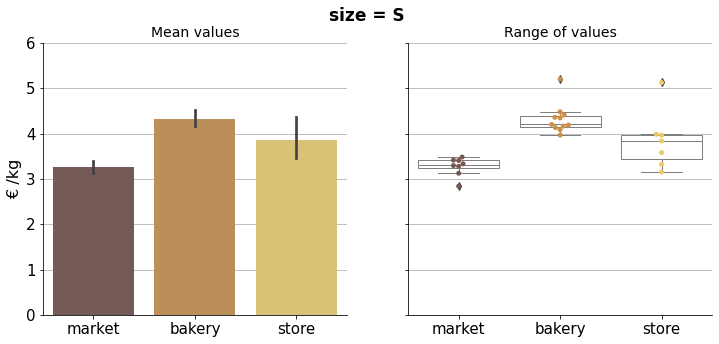

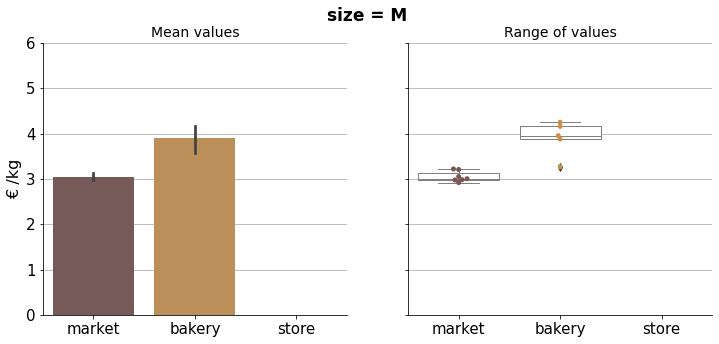

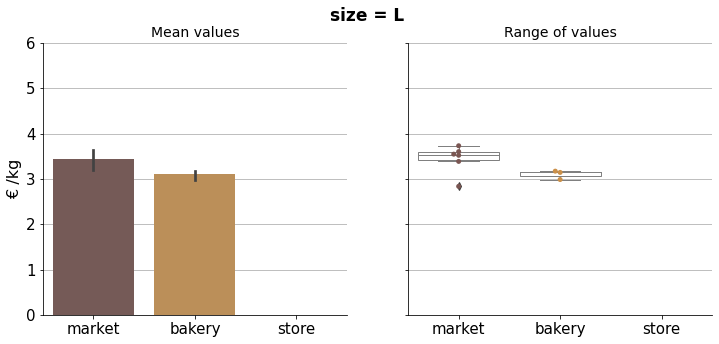

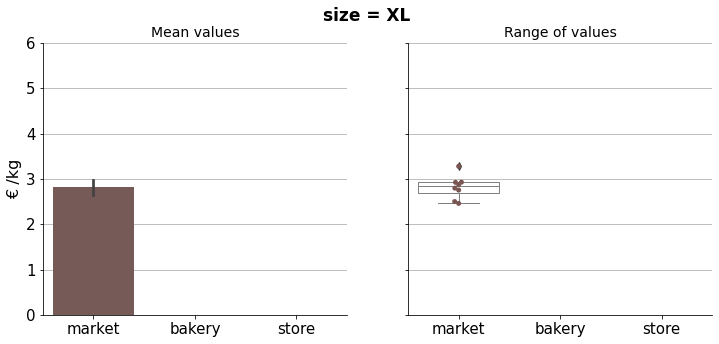

In [60]:
# copy()???
for size in sizes:
    df = breads[breads["size"] == size]

    fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 5))

    fig.suptitle(f'size = {size}', fontsize=17, fontweight="bold")

    sns.despine()

    sns.barplot(x="type", y="eur/kg", data=df, ax=ax[0],
                order=hue_order, palette=palette,
                hue="type", hue_order=hue_order, dodge=False)

    sns.swarmplot(x="type", y="eur/kg", data=df, ax=ax[1],
                order=hue_order, palette=palette,
                hue="type", hue_order=hue_order, dodge=False)
    sns.boxplot(x="type", y="eur/kg", data=df, ax=ax[1],
                order=hue_order, palette=palette,
                hue="type", hue_order=hue_order, dodge=False,
                boxprops=dict(linewidth=1, facecolor='white', edgecolor='grey', alpha=1),
                whiskerprops=dict(linewidth=1, color='grey', alpha=1),
                medianprops=dict(linewidth=1, color="grey", alpha=1),
                capprops=dict(linewidth=1, color='grey', alpha=1),
               )

    for i in range(2):
        ax[i].grid(axis="y")
        ax[i].set_axisbelow(True)
        ax[i].set_xlabel("")
        ax[i].legend().set_visible(False)
        ax[i].tick_params(axis='both', which='major', labelsize=15)

    ax[0].set_ylabel("€ /kg", size=16)
    ax[1].set_ylabel("", size=15)

    ax[0].set_title("Mean values", size=14)
    ax[1].set_title("Range of values", size=14)
    
    ax[0].set_ylim(0, 6)


    plt.show()

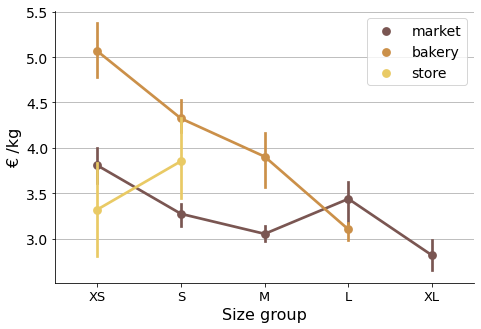

In [61]:
# Plot
fig, ax = plt.subplots(figsize=(7.5, 5))

sns.pointplot(x="size", y="eur/kg", data=breads, ax=ax,
                hue="type", hue_order=hue_order, palette=palette,)

ax.grid(axis="y")
ax.set_axisbelow(True)
ax.tick_params(axis='y', which='major', labelsize=14)
ax.tick_params(axis='x', which='major', labelsize=13)
ax.set_title("", size=15)
ax.set_xlabel("Size group", size=16)
ax.set_ylabel("€ /kg", size=16)
ax.legend(fontsize=14)
sns.despine()

plt.show()

The bar plots above show the mean prices per kilogram, per size and type. As there are multiple observations in each category, the Seaborn function uses bootstrapping to compute a confidence interval around the estimate, which is plotted using error bars. Therefore we can do a simple *visual statistical test* to asses whether prices are significantly different. If error bars do not overlap, there is a statistically significant difference in the prices, i.e. we know that the p-value is less than 0.05 just by looking at the picture.

Error bars indicate 95% confidence intervals, so whenever there is an overlapping we cannot conclude a significant difference.